# Deep Learning Convenience Functions

> This notebook contains convenience functions to aid in modeling. 

In [75]:
#| default_exp dlfn

In [76]:
#| export
import os, re
import math

from tqdm import tqdm

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from EnvDL.core import read_json
from EnvDL.dna import np_3d_to_hilbert

import lightning.pytorch as pl

from graphviz import Digraph # used in VNN

In [77]:
#| hide
from nbdev.showdoc import *

In [78]:
#| export

def calc_cs(x # numeric array
           ): 
    "Calculate nan mean and nan std of an array. Returned as list"
    return [np.nanmean(x, axis = 0), np.nanstd(x, axis = 0)]

In [79]:
#| export

def apply_cs(xs, 
             cs_dict_entry # list of length 2 containing mean and s
            ): return ((xs - cs_dict_entry[0]) / cs_dict_entry[1])

In [80]:
#| export

def reverse_cs(xs, cs_dict_entry): return (cs_dict_entry[1] * xs) + cs_dict_entry[0]

## Train/Validate/Test Split info

Stored as json

In [81]:
#| export

def read_split_info(
    load_from = '../nbs_artifacts/01.06_g2fc_cluster_genotypes/',
    json_prefix = '2023:9:5:12:8:26'):
    ""
    jsons = [e for e in os.listdir(load_from) if re.match('^'+json_prefix+'.+\.json$', e)]
    vals = [e for e in jsons if re.match('.+val\d+\.json$', e)]
    vals.sort()
    out = {}
    out['test'] = [read_json(json_path = load_from+json_prefix+'-test.json')]
    out['test_file'] = [json_prefix+'-test.json']
    out['validate'] = [read_json(json_path = load_from+val) for val in vals]
    out['validate_files'] = [val for val in vals]
    return(out)


In [82]:
#| export

def find_idxs_split_dict(
    obs_df, # assumes presence of Year, Female, Male
    split_dict # from read_split_info() output. Should be a test of validate dict.
):
    temp = obs_df
    test_mask = ((temp.Year.isin(split_dict['test_years'])) & 
                 ((temp.Female.isin(split_dict['test_parents'])) |
                  (temp.Male.isin(split_dict['test_parents']))))
    temp['Split'] = ''
    temp.loc[test_mask, 'Split'] = 'Test'

    train_mask = (~(temp.Year.isin(split_dict['test_years'])) & 
                 (~((temp.Female.isin(split_dict['test_parents'])) |
                  (temp.Male.isin(split_dict['test_parents'])))))
    temp.loc[train_mask, 'Split'] = 'Train'

    temp_test  = (temp.Split == 'Test') # should be the same as with the mask above
    temp_train = (temp.Split == 'Train') # should be the same as with the mask above

    # Confirm that there's no overlap in parents or years
    temp_test_parents  = set(temp.loc[temp_test, 'Female']+temp.loc[temp_test, 'Male'])
    temp_train_parents = set(temp.loc[temp_train, 'Female']+temp.loc[temp_train, 'Male'])

    temp_test_years  = set(temp.loc[temp_test, 'Year'])
    temp_train_years = set(temp.loc[temp_train, 'Year'])

    assert [] == [e for e in temp_test_parents if e in temp_train_parents]
    assert [] == [e for e in temp_train_parents if e in temp_test_parents]
    assert [] == [e for e in temp_test_years if e in temp_train_years]
    assert [] == [e for e in temp_train_years if e in temp_test_years]

    return({
        'test_idx': temp.loc[test_mask, ].index, 
        'train_idx': temp.loc[train_mask, ].index} )

## Initialization

In [83]:
#| export
def LSUV_(model, data, apply_only_to=['Conv', 'Linear', 'Bilinear'],
          std_tol=0.1, max_iters=10, do_ortho_init=True, logging_FN=print):
    r"""
    Refer to https://github.com/glassroom/torch_lsuv_init
    Applies layer sequential unit variance (LSUV), as described in
    `All you need is a good init` - Mishkin, D. et al (2015):
    https://arxiv.org/abs/1511.06422

    Args:
        model: `torch.nn.Module` object on which to apply LSUV.
        data: sample input data drawn from training dataset.
        apply_only_to: list of strings indicating target children
            modules. For example, ['Conv'] results in LSUV applied
            to children of type containing the substring 'Conv'.
        std_tol: positive number < 1.0, below which differences between
            actual and unit standard deviation are acceptable.
        max_iters: number of times to try scaling standard deviation
            of each children module's output activations.
        do_ortho_init: boolean indicating whether to apply orthogonal
            init to parameters of dim >= 2 (zero init if dim < 2).
        logging_FN: function for outputting progress information.

    Example:
        >>> model = nn.Sequential(nn.Linear(8, 2), nn.Softmax(dim=1))                                                                                                                                                                                                                                            
        >>> data = torch.randn(100, 8)
        >>> LSUV_(model, data)
    """

    matched_modules = [m for m in model.modules() if any(substr in str(type(m)) for substr in apply_only_to)]

    if do_ortho_init:
        logging_FN(f"Applying orthogonal init (zero init if dim < 2) to params in {len(matched_modules)} module(s).")
        for m in matched_modules:
            for p in m.parameters():                
                torch.nn.init.orthogonal_(p) if (p.dim() >= 2) else torch.nn.init.zeros_(p)

    logging_FN(f"Applying LSUV to {len(matched_modules)} module(s) (up to {max_iters} iters per module):")

    def _compute_and_store_LSUV_stats(m, inp, out):
        m._LSUV_stats = { 'mean': out.detach().mean(), 'std': out.detach().std() }

    was_training = model.training
    model.train()  # sets all modules to training behavior
    with torch.no_grad():
        for i, m in enumerate(matched_modules):
            with m.register_forward_hook(_compute_and_store_LSUV_stats):
                for t in range(max_iters):
                    _ = model(data)  # run data through model to get stats
                    mean, std = m._LSUV_stats['mean'], m._LSUV_stats['std']
                    if abs(std - 1.0) < std_tol:
                        break
                    m.weight.data /= (std + 1e-6)
            logging_FN(f"Module {i:2} after {(t+1):2} itr(s) | Mean:{mean:7.3f} | Std:{std:6.3f} | {type(m)}")
            delattr(m, '_LSUV_stats')

    if not was_training: model.eval()

## Network Components

In [84]:
#| export
def Linear_block(in_size, out_size, drop_pr):
    block = nn.Sequential(
        nn.Linear(in_size, out_size),
        nn.ReLU(),
        nn.Dropout(drop_pr)
    )
    return(block) 

In [85]:
#| export
def Conv1D_x2_Max_block(in_channels, out_channels, kernel_size, stride, maxpool_size):
    block = nn.Sequential(
        nn.Conv1d(
            in_channels= in_channels, # second channel
            out_channels= out_channels,
            kernel_size= kernel_size,
            stride= stride
        ), 
        nn.Conv1d(
            in_channels= out_channels, 
            out_channels= out_channels,
            kernel_size= kernel_size,
            stride= stride
        ), 
        nn.BatchNorm1d(out_channels),
        nn.MaxPool1d((maxpool_size), stride=stride)
    )
    return(block)

### Resnet Blocks 

#### Resnet For 4d (b, c, h, w) (2d conv)
4d is shown first because this code was adapted from the pytorch implementation of ResNet

In [86]:
#| export
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1):
    # Using https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html as a starting point
    """3x3 convolution with padding"""

    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

In [87]:
#| export
def conv1x1(in_planes: int, out_planes: int, stride: int = 1):

    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [88]:
#| export

class BasicBlock2d(nn.Module):
    expansion = 1
    def __init__(self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: nn.Module = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: nn.Module = None,
        expansion: int = 1
    ) -> None:
        super().__init__()
        # Set up defaults if none was passed in
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width !=  64: raise ValueError('Only groups = 1 and base_width = 64 supported')
        if dilation > 1: raise NotImplementedError('Dilation not supported')

        # self.expansion = expansion # in ResNet v1, this is 1, in ResNet v1.5 it is set to 4

        # self.conv1 = conv3x3(inplanes, planes*self.expansion, stride)
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        # self.conv2 = conv3x3(planes, planes*self.expansion)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [89]:
#| export

class BottleneckBlock2d(nn.Module):
    # This is the block used in ResNet v1.5. It is supposed to be more effective.
    # Main changes are that 
    # - expansion is not set to 1 
    # - now there is a third convolution that happens in the slow path
    #
    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: nn.Module = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: nn.Module = None,
        expansion: int = 4
    ) -> None:        
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
            
        self.expansion = expansion

        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [90]:
#| export

class ResNet2d(nn.Module):
    def __init__(
        self,
        block, #: Type[Union[BasicBlock, Bottleneck]],
        layers, #: List[int],
        num_outputs: int = 1,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation = None, #: Optional[List[bool]] = None,
        norm_layer = None, #: Optional[Callable[..., nn.Module]] = None,
        input_channels = 4
    ) -> None:
        super().__init__()
        # _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(input_channels, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False) # Note that this is 4 not 3
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_outputs)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block, #: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

#### Resnet For 3d (b, c, l) (1d conv)

In [91]:
#| export

def conv0x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1):
    """3x3 convolution with padding"""
    return nn.Conv1d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


In [92]:
#| export

def conv0x1(in_planes: int, out_planes: int, stride: int = 1):
    """1x1 convolution"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [93]:
#| export

class BasicBlock1d(nn.Module):
    expansion = 1
    def __init__(self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: nn.Module = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: nn.Module = None,
        expansion: int = 1
    ) -> None:
        super().__init__()
        # Set up defaults if none was passed in
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
        if groups != 1 or base_width !=  64: raise ValueError('Only groups = 1 and base_width = 64 supported')
        if dilation > 1: raise NotImplementedError('Dilation not supported')

        # self.expansion = expansion # in ResNet v1, this is 1, in ResNet v1.5 it is set to 4

        # self.conv1 = conv3x3(inplanes, planes*self.expansion, stride)
        self.conv1 = conv0x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        # self.conv2 = conv3x3(planes, planes*self.expansion)
        self.conv2 = conv0x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
  

In [94]:
#| export

  
class BottleneckBlock1d(nn.Module):
    # This is the block used in ResNet v1.5. It is supposed to be more effective.
    # Main changes are that 
    # - expansion is not set to 1 
    # - now there is a third convolution that happens in the slow path
    #
    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: nn.Module = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: nn.Module = None,
        expansion: int = 4
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
            
        self.expansion = expansion

        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv0x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv0x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv0x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    


In [95]:
#| export
class ResNet1d(nn.Module):
    def __init__(
        self,
        block, #: Type[Union[BasicBlock, Bottleneck]],
        layers, #: List[int],
        num_outputs: int = 1,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation = None, #: Optional[List[bool]] = None,
        norm_layer = None, #: Optional[Callable[..., nn.Module]] = None,
        input_channels = 4
    ) -> None:
        super().__init__()
        # _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv1d(input_channels, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False) # Note that this is 4 not 3
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(512 * block.expansion, num_outputs)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm1d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block, #: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv0x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)




## Visible Neural Networks

In [96]:
#| export
class VNNHelper():
    def __init__(self, edge_dict, all_values_are_nodes = True) -> None:
        self.edge_dict = edge_dict.copy()
        # handles updating all the lists of node groups (imp, out, edge)
        self._setup_wrapper(all_values_are_nodes)

        self.node_props = {}
        for e in self.node_keys_vals['all_keys']:
            self.node_props[e] = {}

    def _setup_wrapper(self, all_values_are_nodes):
        if all_values_are_nodes:
            self._init_missing_nodes_as_input()
        self.node_keys_vals = self._find_uniq_keys_values(input_dict = self.edge_dict)
        self.nodes_inp = self._find_nodes_inp(all_key_value_dict = self.node_keys_vals)
        self.nodes_out = self._find_top_nodes(all_key_value_dict = self.node_keys_vals)
        self.nodes_edge= self._find_nodes_edge(all_key_value_dict= self.node_keys_vals, nodes_inp= self.nodes_inp, nodes_out = self.nodes_out)
        # sets self.dependancy_order
        self._get_run_order()

    # CRUD operations on node proprty dictionary
    def node_prop_create(self, name):
        self.node_props[name] = {}
        
    def node_prop_read_keys(self, name):
        return self.node_props[name].keys()

    def node_prop_read_values(self, name, key):
        return self.node_props[name][key]

    def node_prop_update(self, name, key, value):
        self.node_props[name][key] = value

    def node_prop_delete(self, name, key=None):
        if key == None:
            del self.node_props[name]
        else:
            del self.node_props[name][key]


    def _find_uniq_keys_values(self, input_dict):
        """
        Building a Neural Net from an arbitrary graph
        start by finding the top level -- all those keys which are theselves not values
        helper function to get all keys and all value from a dict. Useful for when keys don't have unique values.
        """
        all_keys = list(input_dict.keys())
        all_values = []
        for e in all_keys:
            all_values.extend(input_dict[e])
        all_values = list(set(all_values))

        return({'all_keys': all_keys, 'all_values': all_values})

    def _find_top_nodes(self, all_key_value_dict):
        """
        Find order that nodes in the graph should be called to have all dependencies run when they are called.
        find the dependancies for run order from many dependancies to none
        wrapper function to find the nodes that aren't any other nodes dependancies.
        """
        return([e for e in all_key_value_dict['all_keys'] if e not in all_key_value_dict['all_values']])
    
    def _init_missing_nodes_as_input(self):
        node_keys_vals = self._find_uniq_keys_values(input_dict = self.edge_dict)
        add_these_nodes = [e for e in node_keys_vals['all_values'] if e not in node_keys_vals['all_keys']]
        for e in add_these_nodes:
            self.edge_dict[e] = []

    def _find_nodes_inp(self, all_key_value_dict):
        # """
        # wrapper function to find the input nodes. They don't occur in the keys and thus won't be added to the list otherwise.
        # another way to do this would have been to 
        # """
        # return([e for e in all_key_value_dict['all_values'] if e not in all_key_value_dict['all_keys']])
        return [e for e in all_key_value_dict['all_keys'] if self.edge_dict[e] == []]

    def _find_nodes_edge(self, all_key_value_dict, nodes_inp, nodes_out):
        return [e for e in all_key_value_dict['all_keys'] if e not in nodes_inp+nodes_out]

    def append_output_node(self, node_name):
        if node_name in self.edge_dict.keys():
            pass
        else:
            self.edge_dict[node_name] = self.nodes_out
            self._setup_wrapper()
            self.node_prop_create(name = node_name)

    def _get_run_order(self, max_iter = 1000):
        temp = self.edge_dict.copy()
        dependancy_order = []
        # Then iterate
        for _ in range(max_iter): 
            top_nodes = self._find_top_nodes(all_key_value_dict = self._find_uniq_keys_values(input_dict = temp))
            if top_nodes == []:
                break
            else:
                dependancy_order += top_nodes    
                # remove nodes from the graph that are at the 'top' level and haven't already been removed
                for key in [e for e in dependancy_order if e in temp.keys()]:
                    temp.pop(key)

        # reverse to get the order that the nodes should be called
        dependancy_order.reverse()                
        self.dependancy_order = dependancy_order


    def set_node_props(self, key, node_val_zip):
        for name, val in node_val_zip:
            self.node_prop_update(name = name, key=key, value=val)
    
    def calc_edge_inp(self):
        for name in self.nodes_edge + self.nodes_out: 
            inp_size = sum([self.node_prop_read_values(name = e, key= 'out') for e in self.edge_dict[name]])
            self.node_prop_update(name = name, key='inp', value=inp_size)     

    def mk_digraph(self, include = ['node_name', 'inp_size', 'out_size']):
        dot = ''
        dot = Digraph()
        for key in self.node_props.keys():
            key_label = []

            if 'node_name' in include: key_label += [key]
            if 'inp_size' in include: key_label += ['In  '+str(self.node_props[key]['inp'])]
            if 'out_size' in include: key_label += ['Out '+str(self.node_props[key]['out'])]
            
            if len(key_label) == 0:
                key_label = ''
            else:
                key_label = '\n'.join(key_label)

            dot.node(key, key_label)
            for value in self.edge_dict[key]:
                # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
                dot.edge(value, key)    
        return dot
    





In [97]:
# Drawing on example version 

n_obs = 100 # 100 obs for each group
y_true = torch.from_numpy(np.concatenate([
        np.zeros((n_obs, )),
        np.ones( (n_obs, ))], 0)) + .1* torch.rand(2*n_obs,)

input_tensor_dict = {
    'in1': torch.from_numpy(np.concatenate([
        np.zeros((n_obs, 4, 3)),
        np.ones( (n_obs, 4, 3))], 0)),
    'in2': torch.from_numpy(np.concatenate([
        np.zeros((n_obs, 4, 2)),  
        np.ones( (n_obs, 4, 2))], 0))}

x_list_temp = [input_tensor_dict[key].to(torch.float) for key in input_tensor_dict.keys()]
[e.shape for e in x_list_temp]


kegg_connections = {
    'y_hat':['d', 'c'],
    'd':['b'],
    'c':['a'],
    'b':['in2', 'a'],
    'a':['in1'],
    'in1': [],
    'in2': []
}

myvnn = VNNHelper(edge_dict = kegg_connections)

myvnn.nodes_inp

['in1', 'in2']

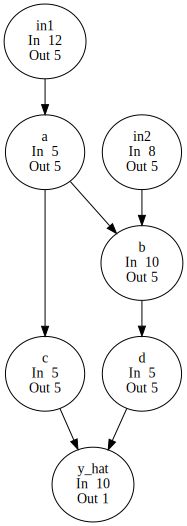

In [98]:
# init input node sizes
inp_tensor_name_to_size = zip(
    ['in1', 'in2'], 
    [int(torch.prod(torch.tensor(e.shape)[1:])) for e in x_list_temp])

myvnn.set_node_props(key = 'inp', node_val_zip = inp_tensor_name_to_size)

# init node output sizes
myvnn.set_node_props(key = 'out', node_val_zip = zip(myvnn.nodes_inp, [5 for e in myvnn.nodes_inp]))
myvnn.set_node_props(key = 'out', node_val_zip = zip(myvnn.nodes_edge,[5 for e in myvnn.nodes_edge]))
myvnn.set_node_props(key = 'out', node_val_zip = zip(myvnn.nodes_out, [1 for e in myvnn.nodes_out]))


# options should be controlled by node_props
myvnn.set_node_props(key = 'flatten', node_val_zip = zip(
    myvnn.nodes_inp, 
    [True for e in myvnn.nodes_inp]))

myvnn.set_node_props(key = 'reps', node_val_zip = zip(
    myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge, 
    [1 for e in myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge]))

# init dropout 
myvnn.set_node_props(key = 'drop', node_val_zip = zip(
    myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge, 
    [0.0 for e in myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge]))

# init edge node input size (propagate forward input/edge outpus)
myvnn.calc_edge_inp()

myvnn.mk_digraph(include = ['node_name', 'inp_size', 'out_size'])

In [99]:
#| export
def Linear_block_reps(in_size, out_size, drop_pr, block_reps):
    block_list = []
    for i in range(block_reps):
        if i == 0:
            block_list += [
                nn.Linear(in_size, out_size),
                nn.ReLU(),
                nn.Dropout(drop_pr)]
        else:
            block_list += [
                nn.Linear(out_size, out_size),
                nn.ReLU(),
                nn.Dropout(drop_pr)]

    block = nn.ModuleList(block_list)
    return(block)     

In [100]:
#| export
class VisableNeuralNetwork(nn.Module):
    def __init__(self, 
                 node_props, 
                 Linear_block,
                 dependancy_order,
                 edge_dict,
                 node_to_inp_num_dict
                ):
        super(VisableNeuralNetwork, self).__init__()
        # Store nodes in dict
        layer_dict = {}
        for key in node_props.keys():
            node_list = []
            if 'flatten' in node_props[key]:
                node_list += [nn.Flatten()]
            node_list += [nn.Flatten()]
            #TODO change linear block instead of conditioning on node name.
            if key != 'y_hat':
                node_list += [Linear_block(
                    in_size=node_props[key]['inp'], 
                    out_size=node_props[key]['out'], 
                    drop_pr=node_props[key]['drop'],
                    block_reps=node_props[key]['reps'])]
            else:
                node_list += [nn.Linear(node_props[key]['inp'], node_props[key]['out'])]

            layer_dict[key] = nn.ModuleList(node_list)

        self.layer_dict = nn.ModuleDict(layer_dict)
        
        self.dependancy_order = dependancy_order
        self.edge_dict = edge_dict
        self.node_to_inp_num_dict = node_to_inp_num_dict

    def forward(self, x):
        temp_res_dict = {}
        for key in self.dependancy_order:
            
            # if the node depends on raw inputs, get them.
            if key in self.node_to_inp_num_dict:
                xin = [ x[self.node_to_inp_num_dict[key]] ]

            # if the node depends on inputs that have been stored in the lookup dict
            if self.edge_dict[key] != []:
                if xin == None:
                    xin = []
                xin += [temp_res_dict[e] for e in self.edge_dict[key]]
                
            # join all input tensors.
            xin = torch.concat(xin, axis = 1)

            for l in self.layer_dict[key]:
                if type(l) == torch.nn.modules.container.ModuleList:
                    for ll in l:            
                        xin = ll(xin)
                else:
                    xin = l(xin)
                    
            temp_res_dict[key] = xin
            xin = None 
        return temp_res_dict[self.dependancy_order[-1]]

In [101]:
model = VisableNeuralNetwork(
    node_props = myvnn.node_props,
    Linear_block = Linear_block_reps,
    edge_dict = myvnn.edge_dict,
    dependancy_order = myvnn.dependancy_order,
    node_to_inp_num_dict = {'in1': 0, 'in2': 1}
)
model(x_list_temp)[0:5]

tensor([[-0.1092],
        [-0.1092],
        [-0.1092],
        [-0.1092],
        [-0.1092]], grad_fn=<SliceBackward0>)

### Deprecated (original) version

In [102]:
## Building a Neural Net from an arbitrary graph
# start by finding the top level -- all those keys which are theselves not values
# helper function to get all keys and all value from a dict. Useful for when keys don't have unique values.
def find_uniq_keys_values(input_dict):
    all_keys = list(input_dict.keys())
    all_values = []
    for e in all_keys:
        all_values.extend(input_dict[e])
    all_values = list(set(all_values))

    return({'all_keys': all_keys,
           'all_values': all_values})
           

In [103]:
### Find order that nodes in the graph should be called to have all dependencies run when they are called.
# find the dependancies for run order from many dependancies to none
# wrapper function to find the nodes that aren't any other nodes dependancies.
def find_top_nodes(all_key_value_dict):
    return([e for e in all_key_value_dict['all_keys'] if e not in all_key_value_dict['all_values']])

In [104]:

# wrapper function to find the input nodes. They don't occur in the keys and thus won't be added to the list otherwise.
# another way to do this would have been to 
def find_input_nodes(all_key_value_dict):
    return([e for e in all_key_value_dict['all_values'] if e not in all_key_value_dict['all_keys']])

In [105]:
#| export

# LOD is list of dicts.
# def kegg_brite_LOD_to_connections(
def kegg_connections_build(
        n_genes, 
        kegg_gene_brite):
    """
    The goal here is to have a dict with each node and a list of it's children. 
    For example, the graph
    a--b--d
    |-c--e
    Would be parsed into     
    {'a':['b', 'c'],
    'b':['d'],
    'c':['e']}
    """
    kegg_connections = {}
    # for all genes in list
    for i in tqdm(range(n_genes)): 
        temp = kegg_gene_brite[i]['BRITE']['BRITE_PATHS']
        # clean up to make sure that there are no ":" characters. These can mess up graphviz
        temp = [[temp[j][i].replace(':', '-') for i in range(len(temp[j])) ] for j in range(len(temp))]
        # all paths through graph associated with a gene
        for j in range(len(temp)):
            # steps of the path through the graph
            for k in range(len(temp[j])-1):
                
                # name standardization 
                temp_jk  = temp[j][k]
                temp_jk1 = temp[j][k+1]
                temp_jk  = temp_jk.lower().title().replace(' ', '')
                temp_jk1 = temp_jk1.lower().title().replace(' ', '')
                
                # if this is a new key, add it and add the k+1 entry as it's child
                if temp_jk  not in kegg_connections.keys():
                    kegg_connections[temp_jk] = [temp_jk1]
                else: 
                    # Check to see if there's a new child to add   
                    if temp_jk1 not in kegg_connections[temp_jk]:
                        # make sure that no key contains itself. This was a problem for 'Others' which is now disallowed.
                        if (temp_jk != temp_jk1):
                            # add it.
                            kegg_connections[temp_jk].extend([temp_jk1])
    return(kegg_connections)          


In [106]:
#| export

def kegg_connections_clean(kegg_connections):
    if 'Others' in kegg_connections.keys():
        del kegg_connections['Others']
        print('Removed node "Others"')

    # remove 'Others' as a possible value
    for key in kegg_connections.keys():
        kegg_connections[key] = [e for e in kegg_connections[key] if e != 'Others']

    # Make sure that no list contains it's own key
    for key in kegg_connections.keys():
        kegg_connections[key] = [e for e in kegg_connections[key] if e != key]

    # there might be associations with no dependants and with no dependants except those that have no dependants.
    # Build up a list with those keys that don't connect back to snps then I'll pass over the connection dict once to remove references to them.
    rm_list = []
    rm_list_i = len(rm_list)
    rm_list_j = -1
    for i in range(100):
        if rm_list_i == rm_list_j:
            break
        else:
            rm_list = [key for key in kegg_connections.keys() if [e for e in kegg_connections[key] if e not in rm_list] == []]
            rm_list_j = rm_list_i 
            rm_list_i = len(rm_list)
    # rm_list

    for key in rm_list:
        del kegg_connections[key]
        
    for key in kegg_connections.keys():
        kegg_connections[key] = [e for e in kegg_connections[key] if e not in rm_list]
    return kegg_connections

In [107]:
#| export

def kegg_connections_append_y_hat(kegg_connections):
    # add yhat node to the graph
    temp_values = []
    for key in kegg_connections.keys():
        temp_values += kegg_connections[key]

    kegg_connections['y_hat'] = [key for key in kegg_connections.keys() if key not in temp_values]
    return kegg_connections

In [108]:
def kegg_connections_digraph(kegg_connections, option = ''):
    dot = ''
    if option == '':
        dot = Digraph()
        for key in tqdm(kegg_connections.keys()):
            dot.node(key)
            for value in kegg_connections[key]:
                # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
                dot.edge(value, key)

    if option == 'number':
        name_to_num_dict = dict(zip(list(kegg_connections.keys()),
                                    [str(i) for i in range(len(list(kegg_connections.keys())))]))

        temp = {}
        for key in kegg_connections.keys():
            temp[name_to_num_dict[key]] = [name_to_num_dict[e] if e in name_to_num_dict.keys() else e for e in kegg_connections[key]]

        dot = Digraph()
        for key in tqdm(temp.keys()):
            dot.node(key)
            for value in temp[key]:
                # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
                dot.edge(value, key)                 
                 
    return dot

In [109]:
def kegg_connections_find_in_out_nodes(kegg_connections):
    # start by finding the top level -- all those keys which are theselves not values
    res = find_uniq_keys_values(input_dict = kegg_connections)
    all_keys = res['all_keys']
    all_values = res['all_values']

    # use the keys to find the input/outputs of the graph
    output_nodes = [e for e in all_keys if e not in all_values]
    input_nodes = [e for e in all_values if e not in all_keys]
    return input_nodes, output_nodes

In [110]:
def kegg_connections_find_dependancy_order(kegg_connections, input_nodes):
    # find the dependancies for run order from many dependancies to none
    temp = kegg_connections.copy()

    no_dependants = find_input_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))
    # first pass. Same as the output nodes identified above
    dependancy_order = []
    # Then iterate
    for ith in range(100): #TODO <- this should be set as a input parameter
        top_nodes = find_top_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))
        if top_nodes == []:
            break
        else:
            dependancy_order += top_nodes    
            # remove nodes from the graph that are at the 'top' level and haven't already been removed
            for key in [e for e in dependancy_order if e in temp.keys()]:
                temp.pop(key)

    # reverse to get the order that the nodes should be called
    dependancy_order.reverse()
    # dependancy_order

    # Trying out new approach: add a node for the input data tha will only flatten the input.
    dependancy_order = input_nodes+dependancy_order

    for key in input_nodes:
        kegg_connections[key] = [] #[key] # needs to contain itself so the model's `get_input_node()` function works 
                                # or that function needs to change.
    
    return kegg_connections, dependancy_order, no_dependants

In [111]:
def kegg_gene_brite_build_node_lookup_dict(kegg_gene_brite):
    # build a dict to go from the node names in `no_dependants` to the list index in `ACGT_gene_slice_list`
    brite_node_to_list_idx_dict = {}
    for i in tqdm(range(len(kegg_gene_brite))):
        brite_node_to_list_idx_dict[str(kegg_gene_brite[i]['BRITE']['BRITE_PATHS'][0][-1])] = i
    return brite_node_to_list_idx_dict

In [112]:
def build_input_tensor_dict(ACGT_gene_slice_list, no_dependants, brite_node_to_list_idx_dict):    
    input_tensor_dict = {}
    for e in no_dependants:
        input_tensor_dict[e] = ACGT_gene_slice_list[brite_node_to_list_idx_dict[e]]
    
    return input_tensor_dict

In [113]:
def setup_network_param_dicts(
        kegg_connections,  # for input sizes
        input_tensor_dict, # for input sizes
        dependancy_order,
        default_output_size,
        default_dropout_pr,
        default_block_reps,
    ):
    # Figure out expected input/output shapes
    #==NOTE! This assumes only dense connections!==

    # This could be replaced by a sort of "distance from output" measure
    output_size_dict = dict(zip(dependancy_order, 
                            [default_output_size for i in range(len(dependancy_order))]))
    output_size_dict['y_hat'] = 1 


    # Setup dropout % dictionary
    dropout_pr_dict = dict(zip(dependancy_order, 
                            [default_dropout_pr for i in range(len(dependancy_order))]))
    dropout_pr_dict['y_hat'] = 0 # not required, output node is purely linear without dropout


    # Setup replicates of layers dictionary
    block_rep_dict = dict(zip(dependancy_order, 
                            [default_block_reps for i in range(len(dependancy_order))]))
    block_rep_dict['y_hat'] = 1 # not required, output node is purely linear. Not a linear block

    # output_size_dict
    # dropout_pr_dict
    # block_rep_dict

    # CHANNEL AWARE VERSION -----------------------------------------------------------------------------------
    input_size_dict = kegg_connections.copy()

    # use the expected output sizes from `output_size_dict` to fill in the non-data sizes
    tensor_ndim = len(input_tensor_dict[list(input_tensor_dict.keys())[0]].shape)
    for e in tqdm(input_size_dict.keys()):
        # overwrite named connections with the output size of those connections
        # if the entry is in no_dependants it's data so it's size needs to be grabbed from the input_tensor_dict
        
        # is there no channel dim? (major/minor allele)
        if 2 == tensor_ndim:
            input_size_dict[e] = [
                list(input_tensor_dict[ee].shape)[-1] # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)
                if ee in no_dependants
                else output_size_dict[ee] for ee in input_size_dict[e]]
        elif 3 == tensor_ndim: # There is a channel dim
            input_size_dict[e] = [
                (list(input_tensor_dict[ee].shape)[1]*list(input_tensor_dict[ee].shape)[2]) # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)  
                if ee in no_dependants
                else output_size_dict[ee] for ee in input_size_dict[e]]

    # Now walk over entries and overwrite with the sum of the inputs
    for e in tqdm(input_size_dict.keys()):
        input_size_dict[e] = np.sum(input_size_dict[e])

    return input_size_dict, output_size_dict, dropout_pr_dict, block_rep_dict


In [114]:
from EnvDL.dlfn import g2fc_datawrapper, BigDataset, plDNN_general

default_output_size = 2
default_dropout_pr = 0.0
default_block_reps = 1


X = g2fc_datawrapper()
X.set_split()
X.load_all(name_list = ['obs_geno_lookup', 'YMat', 'KEGG_slices',], store=True) 
X.calc_cs('YMat', version = 'np', filter = 'val:train')
ACGT_gene_slice_list =     X.get('KEGG_slices', ops_string='')
parsed_kegg_gene_entries = X.get('KEGG_entries')


# Restrict to only those with pathway
kegg_gene_brite = [e for e in parsed_kegg_gene_entries if 'BRITE' in e.keys()]

# also require to have a non-empty path
kegg_gene_brite = [e for e in kegg_gene_brite if not e['BRITE']['BRITE_PATHS'] == []]

print('Retaining '+ str(round(len(kegg_gene_brite)/len(parsed_kegg_gene_entries), 4)*100)+'%, '+str(len(kegg_gene_brite)
    )+'/'+str(len(parsed_kegg_gene_entries)
    )+' Entries'
    )
# kegg_gene_brite[1]['BRITE']['BRITE_PATHS']


kegg_connections = kegg_connections_append_y_hat(
    kegg_connections = kegg_connections_clean(
        kegg_connections = kegg_connections_build(
            n_genes = 2, # 6067, 
            kegg_gene_brite = kegg_gene_brite) ) )

len(list(kegg_connections.keys()))


input_nodes, output_nodes                         = kegg_connections_find_in_out_nodes(kegg_connections= kegg_connections)
kegg_connections, dependancy_order, no_dependants = kegg_connections_find_dependancy_order(kegg_connections= kegg_connections, input_nodes= input_nodes)
brite_node_to_list_idx_dict                       = kegg_gene_brite_build_node_lookup_dict(kegg_gene_brite = kegg_gene_brite)
input_tensor_dict                                 = build_input_tensor_dict(ACGT_gene_slice_list=ACGT_gene_slice_list, no_dependants=no_dependants, brite_node_to_list_idx_dict = brite_node_to_list_idx_dict)

input_size_dict, output_size_dict, dropout_pr_dict, block_rep_dict = setup_network_param_dicts(
        kegg_connections = kegg_connections,
        input_tensor_dict = input_tensor_dict,
        dependancy_order = dependancy_order,
        default_output_size = default_output_size,
        default_dropout_pr = default_dropout_pr,
        default_block_reps = default_block_reps,
    )

Loading and storing default `phno`.
Retaining 43.53%, 6067/13939 Entries


100%|██████████| 27/27 [00:00<00:00, 193583.26it/s]


100%|██████████| 27/27 [00:00<00:00, 55350.05it/s]


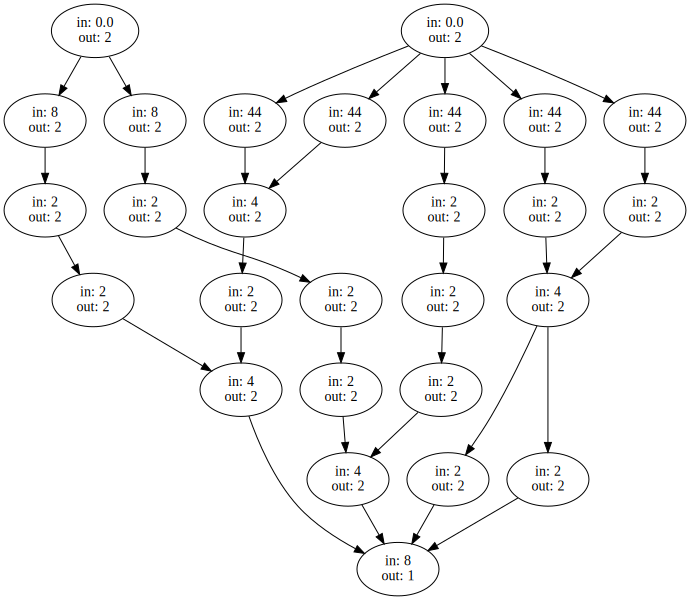

In [115]:
# make in out size graph
dot = ''
dot = Digraph()
for key in tqdm(kegg_connections.keys()):
    key_label = 'in: '+str(input_size_dict[key])+'\nout: '+str(output_size_dict[key])
    dot.node(key, key_label)
    for value in kegg_connections[key
]:
        # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
        dot.edge(value, key)    

dot

In [116]:
# Working version ====
# Doesn't pass output node through relu
class NeuralNetwork(nn.Module):
    def __init__(self, 
                 example_dict, # contains the node (excluding input tensors)
                 example_dict_input_size, # contains the input sizes (including the tensors)
                 example_dict_output_size,
                 example_dict_dropout_pr,
                 example_block_rep_dict,
                 input_tensor_names,
                 dependancy_order
                ):
        super(NeuralNetwork, self).__init__()
        def Linear_block_reps(in_size, out_size, drop_pr, block_reps):
            block_list = []
            for i in range(block_reps):
                if i == 0:
                    block_list += [
                        nn.Linear(in_size, out_size),
                        nn.ReLU(),
                        nn.Dropout(drop_pr)]
                else:
                    block_list += [
                        nn.Linear(out_size, out_size),
                        nn.ReLU(),
                        nn.Dropout(drop_pr)]
        
            block = nn.ModuleList(block_list)
            return(block)           
        
        # fill in the list in dependancy order. 
        layer_list = []
        for key in dependancy_order:
            if key in input_tensor_names:
                layer_list += [
                    nn.Flatten()
                ]
            elif key != 'y_hat':
                layer_list += [
                    Linear_block_reps(in_size=example_dict_input_size[key], 
                                 out_size=example_dict_output_size[key], 
                                 drop_pr=example_dict_dropout_pr[key],
                                 block_reps=example_block_rep_dict[key])
                              ]
            else:
                layer_list += [
                    nn.Linear(example_dict_input_size[key], 
                              example_dict_output_size[key])
                              ]
                

        self.nn_layer_list = nn.ModuleList(layer_list)

        # things for get_input_node in forward to work.
        self.example_dict = example_dict
        self.input_tensor_names = input_tensor_names
        self.dependancy_order = dependancy_order
        
        self.input_tensor_lookup = dict(zip(input_tensor_names, 
                                            [i for i in range(len(input_tensor_names))]))
        self.result_list = []
        self.result_list_lookup = {}
            

    def forward(self, x):
        # Note: x will be a list. input_tensor_lookup will contain the name: list index pairs.
        # I use a dict instead of a list comprehension here because there could be an arbitrarily
        # large number of inputs in the list. 
        def get_input_node(self, input_node, get_x):  
#             print(input_node, self.result_list_lookup)
            return(self.result_list[self.result_list_lookup[input_node]])
        
        # trying reinstantiating to get around inplace replacement issue.
        self.result_list = []
        self.result_list_lookup = {}
        for key in self.dependancy_order:
            input_nodes = self.example_dict[key]
            nn_layer_list_idx = [i for i in range(len(dependancy_order)) if dependancy_order[i]==key][0]
            
            self.result_list_lookup[key] = len(self.result_list_lookup)                
            if key in self.input_tensor_names: # If the input node is an input (flatten) layer
                self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](
                    x[self.input_tensor_lookup[key]]
                ).clone()]

            elif key != 'y_hat':
                # refactored to handle module lists (even if module list contains only one entry)
                out = torch.concat(
                    [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
                    -1)
            
                for module in self.nn_layer_list[nn_layer_list_idx]:
                    out = module(out)
        
                self.result_list = self.result_list + [out] 
            
            else:
                self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](torch.concat(
                    [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
                    -1)).clone()]            

        return self.result_list[self.result_list_lookup['y_hat']]

In [117]:
#| export
class ListDataset(Dataset): # for any G containing matix with many (phno) to one (geno)
    def __init__(self, 
                 y, 
                 x_list,
                 obs_idxs, # this is a list of the indexes used. It allows us to pass in smaller 
                           # tensors and then get the right genotype
                 obs_geno_lookup,
                 transform = None, target_transform = None,
                 **kwargs 
                ):
        if 'device' in kwargs:
            self.device = kwargs['device']
        self.y = y 
        self.x_list = x_list
        self.obs_idxs = obs_idxs
        self.obs_geno_lookup = obs_geno_lookup
        self.transform = transform
        self.target_transform = target_transform    
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        y_idx =self.y[idx]
        
        new_idx = self.obs_idxs[idx]
        idx_geno = self.obs_geno_lookup[new_idx, 1]
        x_idx =[x[idx_geno, ] for x in self.x_list] 
        
        if self.target_transform:
            y_idx = self.transform(y_idx)
            x_idx = [self.transform(x) for x in x_idx]
            
        return y_idx, x_idx

In [118]:
#| export
class plVNN(pl.LightningModule):
    def __init__(self, mod):
        super().__init__()
        self.mod = mod
    def training_step(self, batch, batch_idx):
        y_i, xs_i = batch
        pred = self.mod(xs_i)
        loss = F.mse_loss(pred, y_i)
        self.log("train_loss", loss)   
        return(loss)
        
    def validation_step(self, batch, batch_idx):
        y_i, xs_i = batch
        pred = self.mod(xs_i)
        loss = F.mse_loss(pred, y_i)
        self.log('val_loss', loss)        
     
    def configure_optimizers(self, **kwargs):
        optimizer = torch.optim.Adam(self.parameters(), **kwargs)
        return optimizer    

In [119]:
if True == False:
    x_list_temp = [torch.from_numpy(input_tensor_dict[key]).to(torch.float) for key in input_tensor_dict.keys()]


    training_dataloader = DataLoader(ListDataset(
            y =               X.get('YMat',ops_string='cs filter:val:train asarray from_numpy float cuda:0')[:, None],
            x_list = [e.to('cuda') for e in x_list_temp],
            obs_idxs =        X.get('val:train',       ops_string='   asarray from_numpy      '), 
            obs_geno_lookup = X.get('obs_geno_lookup', ops_string='   asarray from_numpy      ')
        ),
        batch_size = batch_size,
        shuffle = True
    )


    validation_dataloader = DataLoader(ListDataset(
            y =               X.get('YMat',ops_string='cs filter:val:test asarray from_numpy float cuda:0')[:, None],
            x_list = [e.to('cuda') for e in x_list_temp],
            obs_idxs =        X.get('val:test',       ops_string='   asarray from_numpy      '), 
            obs_geno_lookup = X.get('obs_geno_lookup', ops_string='   asarray from_numpy      ')
        ),
        batch_size = batch_size,
        shuffle = True
    )

    model = NeuralNetwork(example_dict = kegg_connections, 
                        example_dict_input_size = input_size_dict,
                        example_dict_output_size = output_size_dict,
                        example_dict_dropout_pr= dropout_pr_dict,
                        example_block_rep_dict = block_rep_dict,
                        input_tensor_names = list(input_tensor_dict.keys()),
                        dependancy_order = dependancy_order)


    model.to('cuda')
    # LSUV_(model, data = next(iter(training_dataloader))[1])
    print(model(next(iter(training_dataloader))[1])[0:5])
    # print(next(model.parameters()))
    # print(model)

    
    VNN = plVNN(model)
    optimizer = VNN.configure_optimizers()

    logger = TensorBoardLogger("tb_vnn_logs", name="vnn-02.31-TESTING-REMOVE-ME")
    trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, precision=16)

    trainer.fit(model=VNN, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)


#### Alternate version (using VNNHelper) 

In [120]:
# Same setup as above to create kegg_gene_brite
X = g2fc_datawrapper()
X.set_split()
X.load_all(name_list = ['obs_geno_lookup', 'YMat', 'KEGG_slices',], store=True) 
X.calc_cs('YMat', version = 'np', filter = 'val:train')
ACGT_gene_slice_list =     X.get('KEGG_slices', ops_string='')
parsed_kegg_gene_entries = X.get('KEGG_entries')


# Restrict to only those with pathway
kegg_gene_brite = [e for e in parsed_kegg_gene_entries if 'BRITE' in e.keys()]

# also require to have a non-empty path
kegg_gene_brite = [e for e in kegg_gene_brite if not e['BRITE']['BRITE_PATHS'] == []]

print('Retaining '+ str(round(len(kegg_gene_brite)/len(parsed_kegg_gene_entries), 4)*100)+'%, '+str(len(kegg_gene_brite)
    )+'/'+str(len(parsed_kegg_gene_entries)
    )+' Entries'
    )
# kegg_gene_brite[1]['BRITE']['BRITE_PATHS']


kegg_connections = kegg_connections_append_y_hat(
    kegg_connections = kegg_connections_clean(
        kegg_connections = kegg_connections_build(
            n_genes = 4, #6067, 
            kegg_gene_brite = kegg_gene_brite) ) )

Loading and storing default `phno`.
Retaining 43.53%, 6067/13939 Entries


100%|██████████| 4/4 [00:00<00:00, 30229.22it/s]


In [121]:
#| export
def kegg_connections_sanitize_names(kegg_connections, replace_chars = {'.':'_'}):
    # have to clean the key values so that none have '.' because I'm looking up nodes by name and pytorch doesn't allow this.
    #NOTE this will potentially (but not here) create a bug if there are genes named with '.'    

    def replace_select_chars(in_str, replace_chars):
        for key in replace_chars.keys():
            in_str = in_str.replace(key, replace_chars[key])
        return in_str

    new_kegg_connections = {}
    for key in kegg_connections.keys():
        new_kegg_connections[replace_select_chars(in_str = key, replace_chars=replace_chars)] = [replace_select_chars(in_str = e, replace_chars=replace_chars) for e in kegg_connections[key]]

    return new_kegg_connections

In [122]:
kegg_connections = kegg_connections_sanitize_names(
    kegg_connections = kegg_connections, 
    replace_chars = {'.':'_'})

In [123]:
# allowed boilerplate.

# initialize helper for input nodes
myvnn = VNNHelper(edge_dict = kegg_connections)

myvnn.nodes_inp[0:10]

# Get a mapping of brite names to tensor list index
find_names = myvnn.nodes_inp # e.g. ['100383860', '100278565', ... ]
lookup_dict = {}

# the only difference lookup_dict and brite_node_to_list_idx_dict above is that this is made using the full set of genes in the list 
# whereas that is made using kegg_gene_brite which is a subset
for i in range(len(parsed_kegg_gene_entries)):
    if 'BRITE' not in parsed_kegg_gene_entries[i].keys():
        pass
    elif parsed_kegg_gene_entries[i]['BRITE']['BRITE_PATHS'] == []:
        pass
    else:
        name = parsed_kegg_gene_entries[i]['BRITE']['BRITE_PATHS'][0][-1]
        if name in find_names:
            lookup_dict[name] = i
lookup_dict    


brite_node_to_list_idx_dict = {}
for i in tqdm(range(len(kegg_gene_brite))):
    brite_node_to_list_idx_dict[str(kegg_gene_brite[i]['BRITE']['BRITE_PATHS'][0][-1])] = i        

# Get the input sizes for the graph
size_in_zip = zip(myvnn.nodes_inp, [np.prod(ACGT_gene_slice_list[lookup_dict[e]].shape[1:]) for e  in myvnn.nodes_inp])


100%|██████████| 6067/6067 [00:00<00:00, 1438080.95it/s]


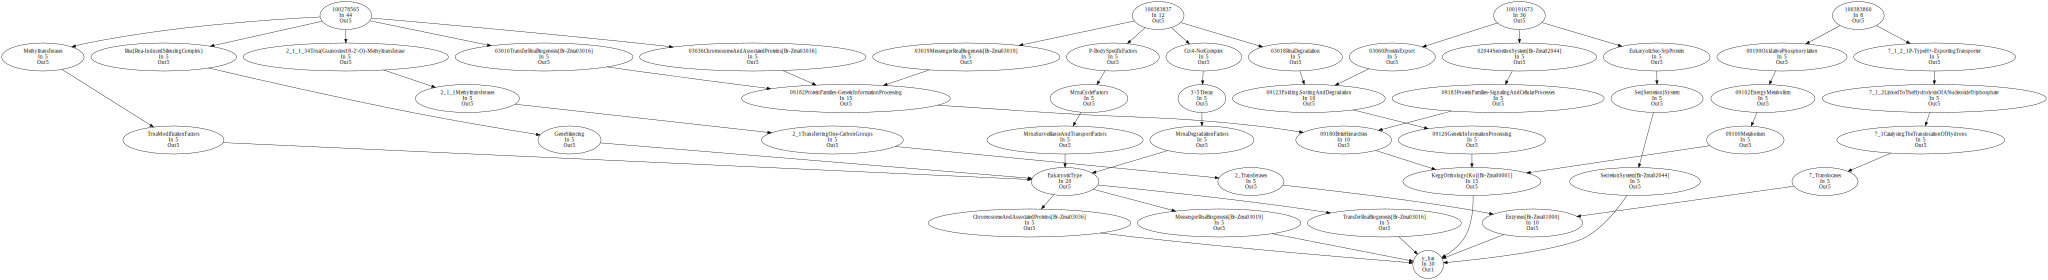

In [124]:
# init input node sizes
myvnn.set_node_props(key = 'inp', node_val_zip = size_in_zip)

# # init node output sizes
myvnn.set_node_props(key = 'out', node_val_zip = zip(myvnn.nodes_inp, [5 for e in myvnn.nodes_inp]))
myvnn.set_node_props(key = 'out', node_val_zip = zip(myvnn.nodes_edge,[5 for e in myvnn.nodes_edge]))
myvnn.set_node_props(key = 'out', node_val_zip = zip(myvnn.nodes_out, [1 for e in myvnn.nodes_out]))


# # options should be controlled by node_props
myvnn.set_node_props(key = 'flatten', node_val_zip = zip(
    myvnn.nodes_inp, 
    [True for e in myvnn.nodes_inp]))

myvnn.set_node_props(key = 'reps', node_val_zip = zip(
    myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge, 
    [1 for e in myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge]))

# init dropout 
myvnn.set_node_props(key = 'drop', node_val_zip = zip(
    myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge, 
    [0.0 for e in myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge]))

# init edge node input size (propagate forward input/edge outpus)
myvnn.calc_edge_inp()

myvnn.mk_digraph(include = ['node_name', 'inp_size', 'out_size'])
# myvnn.mk_digraph(include = [''])

In [125]:
model = VisableNeuralNetwork(
    node_props = myvnn.node_props,
    Linear_block = Linear_block_reps,
    edge_dict = myvnn.edge_dict,
    dependancy_order = myvnn.dependancy_order,

    node_to_inp_num_dict = lookup_dict
)
model = model.to('cuda')
# model.cuda()
next(model.parameters()).is_cuda

model(
    # selectively send the tensors I need to the GPU, replace all others with None. (so it if it fails it fails fast and loudly)
    [torch.tensor(ACGT_gene_slice_list[i]).to(torch.float).to('cuda') if 
    i in [lookup_dict[e] for e in lookup_dict.keys()] # indices to send to gpu
    else None
    for i in range(len(ACGT_gene_slice_list))]
)

tensor([[0.0766],
        [0.0755],
        [0.0766],
        ...,
        [0.0759],
        [0.0759],
        [0.0756]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [126]:
# example where only relevant data is moved to the GPU
if True == False:
    batch_size = 24

    sparce_list = [
        # selectively send the tensors I need to the GPU, replace all others with None. (so it if it fails it fails fast and loudly)
        torch.tensor(ACGT_gene_slice_list[i]).to(torch.float).to('cuda') if 
        i in [lookup_dict[e] for e in lookup_dict.keys()] # indices to send to gpu
        else torch.tensor(ACGT_gene_slice_list[i]).to(torch.float) # keep on cpu (not needed)
        for i in range(len(ACGT_gene_slice_list))]


    training_dataloader = DataLoader(ListDataset(
            y =               X.get('YMat',ops_string='cs filter:val:train asarray from_numpy float cuda:0')[:, None],
            x_list = sparce_list,
            obs_idxs =        X.get('val:train',       ops_string='   asarray from_numpy      '), 
            obs_geno_lookup = X.get('obs_geno_lookup', ops_string='   asarray from_numpy      ')
        ),
        batch_size = batch_size,
        shuffle = True
    )


    validation_dataloader = DataLoader(ListDataset(
            y =               X.get('YMat',ops_string='cs filter:val:test asarray from_numpy float cuda:0')[:, None],
            x_list = sparce_list,
            obs_idxs =        X.get('val:test',        ops_string='   asarray from_numpy      '), 
            obs_geno_lookup = X.get('obs_geno_lookup', ops_string='   asarray from_numpy      ')
        ),
        batch_size = batch_size,
        shuffle = False
    )

    VNN = plVNN(model)
    optimizer = VNN.configure_optimizers()

    logger = TensorBoardLogger("tb_vnn_logs", name="vnn-02.31-TESTING-REMOVE-ME")
    trainer = pl.Trainer(max_epochs=max_epoch, logger=logger)

    trainer.fit(model=VNN, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

## Training (general)

In [127]:
#| export
def train_loop(dataloader, model, loss_fn, optimizer, silent = False):
    size = len(dataloader.dataset)
    for batch, (xs_i, y_i) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(xs_i)
        loss = loss_fn(pred, y_i) # <----------------------------------------

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(y_i) # <----------------
            if not silent:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [128]:
#| export

def train_error(dataloader, model, loss_fn, silent = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0

    with torch.no_grad():
        for xs_i, y_i in dataloader:
            pred = model(xs_i)
            train_loss += loss_fn(pred, y_i).item() # <----------------------
            
    train_loss /= num_batches
    return(train_loss) 

In [129]:
#| export

def test_loop(dataloader, model, loss_fn, silent = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for xs_i, y_i in dataloader:
            pred = model(xs_i)
            test_loss += loss_fn(pred, y_i).item() # <-----------------------

    test_loss /= num_batches
    if not silent:
        print(f"Test Error: Avg loss: {test_loss:>8f}")
    return(test_loss) 

In [130]:
#| export

def yhat_loop(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    y_true = np.array([])
    y_pred = np.array([])
    
    with torch.no_grad():
        for xs_i, y_i in dataloader:
            yhat_i = model(xs_i)
            y_pred = np.append(y_pred, np.array(yhat_i.cpu()))
            y_true = np.append(y_true, np.array(y_i.cpu()))
    
    out = np.concatenate([y_true[:, None], y_pred[:, None]], axis = 1) 
    out = pd.DataFrame(out, columns = ['y_true', 'y_pred'])
    return(out)

In [131]:
#| export

def train_nn(
    cache_path,
    training_dataloader,
    testing_dataloader,
    model,
    learning_rate = 1e-3,
    batch_size = 64,
    epochs = 500,
    model_prefix = 'model'
):
    # Initialize the loss function
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_df = pd.DataFrame([i for i in range(epochs)], columns = ['Epoch'])
    loss_df['TrainMSE'] = np.nan
    loss_df['TestMSE']  = np.nan

    for t in tqdm(range(epochs)):        
        # print(f"Epoch {t+1}\n-------------------------------")
        train_loop(training_dataloader, model, loss_fn, optimizer, silent = True)

        loss_df.loc[loss_df.index == t, 'TrainMSE'
                   ] = train_error(training_dataloader, model, loss_fn, silent = True)
        
        loss_df.loc[loss_df.index == t, 'TestMSE'
                   ] = test_loop(testing_dataloader, model, loss_fn, silent = True)
        
        if (t+1)%5 == 0: # Cache in case training is interupted. 
            # print(loss_df.loc[loss_df.index == t, ['TrainMSE', 'TestMSE']])
            torch.save(model.state_dict(), 
                       cache_path+'/'+model_prefix+'_'+str(t)+'_'+str(epochs)+'.pt') # convention is to use .pt or .pth
        
    return([model, loss_df])

In [132]:
#| export

def estimate_iterations(sec_per_it = 161):
    hours = [1, 2, 4, 8, 12, 24]
    res = pd.DataFrame(zip(hours, 
    [math.floor(
        ((i)*(60*60))/sec_per_it
    ) for i in hours]), columns = ['Hours', 'Iterations'])
    return(res)

In [133]:
#| export
class ACGTDataset(Dataset): # for any G containing matix with many (phno) to one (geno)
    def __init__(self, 
                 y, 
                 G, # not on gpu
                 idx_original,
                 idx_lookup,
                 transform = None, target_transform = None,
                 use_gpu_num = 0,
                 device = 'cuda',
                 **kwargs 
                ):

        self.device = device
        self.y = y 
        self.G = G
        self.idx_original = idx_original
        self.idx_lookup = idx_lookup
        self.transform = transform
        self.target_transform = target_transform    
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        y_idx =self.y[idx]
            
        #                 |array containing correct index in deduplicated g 
        #                 |               index in phno    
        uniq_g_idx = self.idx_lookup[self.idx_original[idx], 1]
        g_idx = self.G[uniq_g_idx, :, :]
        
        # send all to gpu        
        if (self.device != 'cpu'):
            if y_idx.device.type == 'cpu':
                y_idx = y_idx.to(self.device) 
                
            if g_idx.device.type == 'cpu':
                g_idx = g_idx.to(self.device) 
        
        
        if self.transform:
            g_idx = self.transform(g_idx)
            
        if self.target_transform:
            y_idx = self.transform(y_idx)
        return g_idx, y_idx

## For Multiple Inputs (but not requiring multiple inputs)

In [134]:
send_batch_to_gpu = 'cuda:0'
# send_batch_to_gpu = '0'

# res.to(int(ops.split(':')[-1]))

if len(send_batch_to_gpu) >= 1:
    # remove characters in 'cuda:'
    send_batch_to_gpu = ''.join([e for e in send_batch_to_gpu if e not in ['c', 'u', 'd', 'a', ':']])

send_batch_to_gpu = int(send_batch_to_gpu)
send_batch_to_gpu



0

In [135]:
#| export
class BigDataset(Dataset):
    def __init__(
        self,
        lookup_obs,
        lookups_are_filtered = False, # This is a critical piece of information. For deduplicated lookups to work they must either be filtered so that the 
                                      # lookup's length matchs y's length (idx will map to the right row) _or_ instead lookup_obs must contain a mapping 
                                      # from the y's current length to the row in the full dataset. 
                                      # If False idx -> lookup_obs[idx] -> lookup_env[idx] -> W[idx]
                                      # If True  idx ------------------ -> lookup_env[idx] -> W[idx]
#         lookup_geno,
#         lookup_env,
#         y,
#         G, 
#         G_type
#         S,
#         P,
#         W,
#         W_type,
#         send_batch_to_gpu # 'cuda:0' but '0' and 'cuda0' would also work
        transform = None, 
        target_transform = None,
        **kwargs 
        ):
        """
        This class produces a set with one or more input tensors. For flexibility the only _required_ input is `lookup_obs`, a tensor with the index of observations. 
        Everything else is provided as a kwarg. Output is a list of tensors1 ordered [y, G, S, W], any of these not initalized will be missing but not empty (e.g. [y, S, W] not [y, None, S, W]).       
        Used inputs are:
        lookup_obs: index for y, used by __getitem__ for obs_idx
        lookup_geno: index for G, row obs_idx, column 1 is geno_idx (geno information is deduplicated, hence the need for a lookup)
        lookup_env: index for S & W, , row obs_idx, column 1 is env_idx (env information is deduplicated, hence the need for a lookup)
        y: yield
        G: Genomic information 
        G_type: how the infomation should be returned, 'raw', 'hilbert', or 'list' (i.e. of tensors for snps in each gene)
        S: Soil information
        P: Planting/Harvest date contained in column 0, 1 respectively 
        W: Weather data
        W_type: how the infomation should be returned, 'raw' or 'hilbert'

        1 G may also be returned as a list of tensors
        """
        # Lookup info (so that deduplication works)
        self.lookup_obs = lookup_obs
        self.lookups_are_filtered = lookups_are_filtered
        # if 'lookup_obs'  in kwargs: self.lookup_obs  = kwargs['lookup_obs'];
        if 'lookup_geno' in kwargs: self.lookup_geno = kwargs['lookup_geno'];
        if 'lookup_env'  in kwargs: self.lookup_env  = kwargs['lookup_env'];
        # Data
        if 'y' in kwargs: self.y = kwargs['y'];
        if 'G' in kwargs: self.G = kwargs['G'];
        if 'S' in kwargs: self.S = kwargs['S'];
        if 'P' in kwargs: self.P = kwargs['P']; # PlantHarvest so that planting can be added into W
        if 'W' in kwargs: self.W = kwargs['W'];
        # Data prep state information
        if 'G_type' in kwargs: self.G_type = kwargs['G_type']; # raw, hilbert, list
        if 'W_type' in kwargs: self.W_type = kwargs['W_type']; # raw, hilbert
        # Data to be returned
        self.out_names = [e for e in ['y', 'G', 'S', 'W'] if e in kwargs]

        # Is data starting on the desired device or does it need to be cycled on and off?
        # This is based on ACGTDataset
        self.send_batch_to_gpu = None
        if 'send_batch_to_gpu' in kwargs.keys():
            send_batch_to_gpu = kwargs['send_batch_to_gpu']
            if type(send_batch_to_gpu) == str: 
                send_batch_to_gpu = send_batch_to_gpu.lower()
                if len(send_batch_to_gpu) >= 1:
                    # remove characters in 'cuda:'
                    send_batch_to_gpu = ''.join([e for e in send_batch_to_gpu if e not in ['c', 'u', 'd', 'a', ':']])
                self.send_batch_to_gpu = int(send_batch_to_gpu)
            elif type(send_batch_to_gpu) == int: 
                self.send_batch_to_gpu = send_batch_to_gpu
            else:
                print('send_batch_to_gpu kwarg ignored. Must be a string or int. Ideally of form "cuda:0"')

        # Transformations
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.lookup_obs)
    

    # These used to be in __getitem__ but separating them like this allows for them to be overwritten more easily
    def get_y(self, idx):
        y_idx = self.y[idx]
        if self.transform:
            y_idx = self.transform(y_idx)
        return(y_idx)
        
    def get_G(self, idx):
        geno_idx = self.lookup_geno[idx, 1]
        if self.G_type in ['raw', 'hilbert']:
            G_idx = self.G[geno_idx]
        if 'list' == self.G_type:
            G_idx = [e[geno_idx] for e in self.G]
        if self.transform:
            G_idx = self.transform(G_idx)
        return(G_idx)

    def get_S(self, idx):
        env_idx = self.lookup_env[idx, 1]
        S_idx = self.S[env_idx]
        if self.transform:
            S_idx = self.transform(S_idx)
        return(S_idx)

    def get_W(self, idx):
        W_device = torch.Tensor(self.W).get_device()

        env_idx = self.lookup_env[idx, 1]
        # get growing information
        WPlant = np.zeros(365)
        # WPlant[self.P[obs_idx, 0]:self.P[obs_idx, 1]] = 1
        WPlant[self.P[idx, 0]:self.P[idx, 1]] = 1
        if self.W_type == 'raw':
            WPlant = torch.from_numpy(WPlant).to(torch.float)
            # if needed send to gpu
            if W_device != -1: WPlant = WPlant.to(W_device)            
            W_idx = torch.concatenate([self.W[env_idx], WPlant[None, :]], axis = 0)
        if self.W_type == 'hilbert':
            # convert growing info to hilbert curve
            WPlant_hilb = np_3d_to_hilbert(WPlant[None, :, None], silent = True)
            WPlant_hilb = WPlant_hilb.squeeze(axis = 3)
            WPlant_hilb[np.isnan(WPlant_hilb)] = 0
            WPlant_hilb = torch.from_numpy(WPlant_hilb).to(torch.float)
            # if needed send to gpu
            if W_device != -1: WPlant_hilb = WPlant_hilb.to(W_device)
            W_idx = torch.concatenate([self.W[env_idx], WPlant_hilb], axis = 0)
        if self.transform:
            W_idx = self.transform(W_idx)
        return(W_idx)
    
    def __getitem__(self, idx):
        out = []
        obs_idx = idx
        if self.lookups_are_filtered == False:
            obs_idx = self.lookup_obs[idx]

        if 'y' in self.out_names: out += [self.get_y(obs_idx)]
        if 'G' in self.out_names: out += [self.get_G(obs_idx)]
        if 'S' in self.out_names: out += [self.get_S(obs_idx)]
        if 'W' in self.out_names: out += [self.get_W(obs_idx)]

        # send all to gpu    
        if self.send_batch_to_gpu is not None:
            out = [[ee.to(self.send_batch_to_gpu) for ee in e] if type(e)==list else e.to(self.send_batch_to_gpu) for e in out]     

        return out


# using send_batch_to_gpu to reduce needed memory

# X = g2fc_datawrapper()
# X.set_split()
# X.load_all(name_list = ['obs_geno_lookup', 'YMat', 'ACGT',], store=True) 

# X.calc_cs('YMat', version = 'np', filter = 'val:train')
# X.calc_cs('ACGT',                 filter = 'val:train', filter_lookup= 'obs_geno_lookup')

# training_dataloader = DataLoader(BigDataset(
#     lookups_are_filtered = False,
#     lookup_obs  = X.get('val:train',       ops_string='asarray from_numpy      '),
#     lookup_geno = X.get('obs_geno_lookup', ops_string='asarray from_numpy      '),
#     # y =           X.get('YMat',            ops_string='asarray from_numpy float')[:, None],
#     # G =           X.get('ACGT',            ops_string='        from_numpy float'),
#     # G_type = 'raw',
#     G =           X.get('KEGG_slices',     ops_string='        from_numpy float'),
#     G_type = 'list',
#     send_batch_to_gpu = 'cuda:0'
#     ),
#     batch_size = 10,
#     shuffle = True
# )

#                                      # 21184MiB needed for full dataset.
# gi = next(iter(training_dataloader)) #   470MiB GPU used after being called

In [136]:
# This dataset is flexible but one must be cautios in setting it up.
# Since weather and genomic data have duplicates the _deduplicated_ data is stored.
# As a result there must be a mapping between yield and the covairates to be retrieved
# This information is stored in lookup tables (lookup_env, lookup_geno)
# This can be achieved in two ways: 
# 1. Take idx for y (which is filtered to only train/validation data), 
#    Lookup y's original idx using lookup_obs
#    Use _that_ index to get the right enviromental/genomic index
#    This approach is used if lookups_are_filtered == False
# 2. Filter the lookup tables so that idx for y is the correct row in the lookup table
#    This should be slightly less memory intensive (lookup tables are smaller) but is 
#    counting on the user to not forget to pre-filter these tables.
#    this approach is used if lookups_are_filtered == True



# if lookup_obs doesn't do anything then this filtering trick works.
# note that here instead of filtering y to only the relevant obs i.e.:
#     y =          X.get('YMat',           ops_string='filter:val:train asarray from_numpy float cuda:0'),
# the full set is included.

# training_dataloader = DataLoader(BigDataset(
#     lookups_are_filtered = True,
#     lookup_obs = X.get('val:train',      ops_string='                 asarray from_numpy             '),
#     lookup_env = X.get('obs_env_lookup', ops_string='filter:val:train asarray from_numpy             '),
#     y =          X.get('YMat',           ops_string='                 asarray from_numpy float cuda:0'),
#     W =          X.get('WMat_hilb',      ops_string='                         from_numpy float cuda:0'),
#     P =          X.get('PlantHarvest',   ops_string='                         from_numpy             '),
#     W_type = 'hilbert'
#     ),
#     batch_size = 2,
#     shuffle = True
# )

# training_dataloader = DataLoader(BigDataset(
#     lookups_are_filtered = False,
#     lookup_obs = X.get('val:train',      ops_string='asarray from_numpy             '),
#     lookup_env = X.get('obs_env_lookup', ops_string='asarray from_numpy             '),
#     y =          X.get('YMat',           ops_string='asarray from_numpy float cuda:0'),
#     W =          X.get('WMat_hilb',      ops_string='        from_numpy float cuda:0'),
#     P =          X.get('PlantHarvest',   ops_string='        from_numpy             '),
#     W_type = 'hilbert'
#     ),
#     batch_size = 50,
#     shuffle = True
# )


In [137]:
#| export

# Standard data prep

# Wrapper function to hide the steps of loading data
import numpy as np
from EnvDL.core import get_cached_result
from EnvDL.dlfn import read_split_info, find_idxs_split_dict
import pandas as pd
import torch

class g2fc_datawrapper():   
    def __init__(self):
        self.data_dict = {}
        self.cs_dict = {}
        print('Loading and storing default `phno`.')
        self.load(name='phno', store = True)
    

    def set_split(self, load_from = '../nbs_artifacts/01.06_g2fc_cluster_genotypes/', json_prefix = '2023:9:5:12:8:26'):
        if 'phno' not in self.data_dict.keys():
            print('`phno` must be stored!\nManually initialize with .load()')
        else:
            split_info = read_split_info(load_from = load_from, json_prefix = json_prefix)

            temp = self.data_dict['phno'].copy()
            temp[['Female', 'Male']] = temp['Hybrid'].str.split('/', expand = True)

            self.test_dict = find_idxs_split_dict(
                obs_df = temp, 
                split_dict = split_info['test'][0]
            )

            temp = temp.loc[self.test_dict['train_idx'], ] # restrict before re-aplying

            self.val_dict = find_idxs_split_dict(
                obs_df = temp, 
                split_dict = split_info['validate'][0]
            )

    def generic_load(self, load_from, file_name):        
        if   file_name.split('.')[-1] == 'pkl': res = get_cached_result(load_from+file_name)
        elif file_name.split('.')[-1] == 'npy': res = np.load(load_from+file_name)
        elif file_name.split('.')[-1] == 'csv': res = pd.read_csv(load_from+file_name)
        else: print(f'Unrecognized file encoding: {file_name.split(".")[-1]} \nReturning None'); res = None
        return res

    def load(self, name='ACGT', store = False, **kwargs):
        # defaults for quick access
        defaults_dict = {
            ## Genomic Data
            'ACGT':         ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'ACGT.npy'],
            'ACGT_hilb':    ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'ACGT_hilb.npy'],            
            'KEGG_entries': ['../nbs_artifacts/01.05_g2fc_demo_model/', 'filtered_kegg_gene_entries.pkl'],
            'KEGG_slices':  ['../nbs_artifacts/01.05_g2fc_demo_model/', 'ACGT_gene_slice_list.pkl'],

            ## Soil and Management 
            'mgmtMatNames': ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'mgmtMatNames.npy'],
            'mgmtMat':      ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'mgmtMat.npy'],
            'SMatNames':    ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'SMatNames.npy'],
            'SMat':         ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'SMat.npy'],

            ## Weather
            'PlantHarvestNames': ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'PlantHarvestNames.npy'],
            'PlantHarvest':      ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'PlantHarvest.npy'],
            'WMat':              ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'WMat.npy'],
            'WMatNames':         ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'WMatNames.npy'],
            'WMat_hilb':         ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'WMat_hilb.npy'],

            # Response and lookup
            'phno':            ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'phno_geno.csv'],
            'obs_geno_lookup': ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'obs_geno_lookup.npy'], # Phno_Idx  Geno_Idx  Is_Phno_Idx
            'obs_env_lookup':  ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'obs_env_lookup.npy'],  # Phno_Idx  Env_Idx   Is_Phno_Idx
            'YMat':            ['../nbs_artifacts/01.03_g2fc_prep_matrices/', 'YMat.npy']
        }

        if name in defaults_dict.keys():
            load_from, file_name = defaults_dict[name]
        else: 
            print(f'`name` not recognized. Use `load_from` and `file_name` for greater control.\,Allowed `names` are:\n{list(defaults_dict.keys())}')
        
        # overwrite defaults if desired
        if 'load_from' in kwargs.keys(): load_from = kwargs['load_from']
        if 'file_name' in kwargs.keys(): file_name = kwargs['file_name']

        res = self.generic_load(load_from=load_from, file_name= file_name)

        if store:
            self.data_dict[name] = res
        else:
            return res

    def load_all(self, name_list = [], store = False):
        if store:
            for e in name_list:
                self.load(name = e, store=store)
        else:
            res_list = []
            for e in name_list:
                res_list += [self.load(name = e, store=store)]
            return res_list

    def store_cs(self, name, cs_list):
        self.cs_dict[name] = cs_list

    def calc_cs(self, name, version = 'np', **kwargs):

        res = self.data_dict[name]
        if 'filter' in kwargs.keys():
            which_dict, which_split = kwargs['filter'].split(':')

            if which_split == 'train':  key = 'train_idx'
            elif which_split == 'test': key = 'test_idx'
            else: print('only `train` and `test` indexes are allowed.')

            if which_dict == 'val':    mask = self.val_dict[key]
            elif which_dict == 'test': mask = self.test_dict[key]
            else: print('only `val` and `test` sets are allowed.')

            if 'filter_lookup' in kwargs.keys():
                # This block exists because some data is deduplicated. In the dataloader I use lookup tables to find the right values.
                # That gets messy because the enviroment, genome, and yield all get different ones
                # I could hardcode names to filters but that would make this code pretty inflexible (which I would like to avoid.)
                # using the manual overwrite metod .store_cs() it's possible to get the desired behavior like this:
                # X.store_cs('WMat', calc_cs(X.get('WMat')[np.array(list(set(X.get('obs_env_lookup', ops_string='filter:val:train')[:, 1]))),: ,:]))
                # That is a lot messier looking than I would like. It's hard to see what's happening. 
                # To get around this I'm adding a 'filter_lookup' kwarg that does the same job as the lookup tables in the data loader.
                lookup = self.data_dict[kwargs['filter_lookup']]
                lookup = lookup[mask, 1]
                # deduplicate; for cs we don't need the order of the obs.
                mask = np.array(list(set(lookup)))
            res = res[mask]

        else:
            print('''
Scaling based on ALL data. To avoid this pass in a split to be used. 
If a lookup table should be used to select observations (e.g. obs_env_lookup ) its name should be passed in. 
E.g. filter = \'val:train\',  filter_lookup = \'obs_env_lookup\'
                  ''')

        if version == 'np':
            self.cs_dict[name] = [np.asarray(np.mean(res, axis = 0)), np.asarray(np.std(res, axis = 0))]
        elif version == 'torch':
            self.cs_dict[name] = [torch.Tensor.mean(res, axis = 0), torch.Tensor.std(res, axis = 0)]

    def calc_cs_all(self, name_list, version = 'np', **kwargs):
        for name in name_list:
            self.calc_cs(name=name, version = version, **kwargs)

    def apply_cs(self, name, **kwargs):
        if name not in self.cs_dict.keys():
            self.calc_cs(name, kwargs)

        vals = self.cs_dict[name]
        res = self.data_dict[name]
        
        if type(res) == type(vals[0]):
            pass
        elif type(res) == torch.Tensor:
            # convert to pytorch
            vals = [torch.from_numpy(e) for e in vals]
        elif type(res) == np.ndarray:
            # convert to numpy
            vals = [torch.Tensor.numpy(e) for e in vals]
            
        center, scale = vals
        res = (res - center) / scale
        return res

    def get_cs(self, name):
        if name not in self.cs_dict.keys():
            res = None
        else:
            res = self.cs_dict[name]
        return res

    def reverse_cs(self, name, x):
        vals = self.cs_dict[name]

        if type(x) == type(vals[0]):
            pass
        elif type(x) == torch.Tensor:
            # convert to pytorch
            vals = [torch.from_numpy(e) for e in vals]
        elif type(res) == np.ndarray:
            # convert to numpy
            vals = [torch.Tensor.numpy(e) for e in vals]

        center, scale = vals
        res = (res * scale) + center
        return res

    
    def get(self, name, ops_string = ''):
        # is split info being requested? (for lookup_obs most likely). Otherwise main data is being requested.
        if name not in ['val:train', 'test:train', 'val:test', 'test:test']:
            if name not in self.data_dict.keys():
                self.load(name, store=True)
            res = self.data_dict[name]
        else: 
            which_dict, which_split = name.split(':')

            if which_split == 'train':  key = 'train_idx'
            elif which_split == 'test': key = 'test_idx'
            else: print('only `train` and `test` indexes are allowed.')

            if which_dict == 'val':    res = self.val_dict[key]
            elif which_dict == 'test': res = self.test_dict[key]
            else: print('only `val` and `test` sets are allowed.')
            
        # apply opperations
        ops_string = [e for e in ops_string.split(' ') if e != '']
        for ops in ops_string:
            if ops[0:6] == 'filter':
                #FIXME Identified a bug on 12/14 where the ops string 
                # 'cs filter:val:train asarray from_numpy float cuda:0
                # works exactly as expected but filtering before cs
                # 'filter:val:train cs asarray from_numpy float cuda:0
                # causes NO filtering to occur. 
                _, which_dict, which_split = ops.split(':')

                if which_split == 'train':  key = 'train_idx'
                elif which_split == 'test': key = 'test_idx'
                else: print('only `train` and `test` indexes are allowed.')

                if which_dict == 'val':    res_idx = self.val_dict[key]
                elif which_dict == 'test': res_idx = self.test_dict[key]
                else: print('only `val` and `test` sets are allowed.')

                if type(res) == list: 
                    res = [e[res_idx] for e in res]
                else:
                    res = res[res_idx]

            if ops == 'cs':
                res = self.apply_cs(name)
            
            if ops == 'asarray':
                if type(res) == list: 
                    res = [np.asarray(e) for e in res]
                else:
                    res = np.asarray(res)
            if ops == 'from_numpy':
                if type(res) == list: 
                    res = [torch.from_numpy(e) for e in res]
                else:
                    res = torch.from_numpy(res)
            if ops == 'float':
                if type(res) == list: 
                    res = [e.to(torch.float) for e in res]
                else:
                    res = res.to(torch.float)
            if ops[0:4] == 'cuda':
                # send to device by number. e.g. cuda:0 -> X.to(0)
                if type(res) == list: 
                    dev_int = int(ops.split(':')[-1])
                    res = [e.to(dev_int) for e in res]
                else:
                    res = res.to(int(ops.split(':')[-1]))

        return res


# some example usage 
# X = g2fc_datawrapper()
# X.set_split()
# X.load_all(name_list = ['obs_env_lookup', 'YMat', 'PlantHarvest', 'WMat',], store=True) 
# X.calc_cs('YMat', version = 'np', filter = 'val:train'); X.cs_dict['YMat']
# X.calc_cs_all(['YMat'], version = 'np', filter = 'val:train'); X.cs_dict['YMat']
# X.calc_cs('YMat', version = 'np'); X.cs_dict['YMat']

# some demonstration of when to use kwargs for scaling 
# how do I manually do scaling for enviromental things?
# X.store_cs('WMat', calc_cs(X.get('WMat')[np.array(list(set(X.get('obs_env_lookup', ops_string='filter:val:train')[:, 1]))),: ,:]))
# [e[0:3, 0] for e in X.cs_dict['WMat']]
# X.calc_cs('WMat', filter = 'val:train', filter_lookup= 'obs_env_lookup')
# [e[0:3, 0] for e in X.cs_dict['WMat']]
# X.calc_cs('WMat')
# [e[0:3, 0] for e in X.cs_dict['WMat']]

# X.get('WMat', ops_string='asarray')[0:3, 0:3, 0]
# X.get('WMat', ops_string='cs asarray')[0:3, 0:3, 0]


## PyTorch Lighning Trainers

In [138]:
#| export

class plDNN_general(pl.LightningModule):
    def __init__(self, mod, log_weight_stats = False):
        super().__init__()
        self.mod = mod
        self.log_weight_stats = log_weight_stats
        
    def training_step(self, batch, batch_idx):
        y_i, x_i = batch
        pred = self.mod(x_i)
        loss = F.mse_loss(pred, y_i)
        self.log("train_loss", loss)
        
        if self.log_weight_stats:
            with torch.no_grad():
                weight_list=[(name, param) for name, param in model.named_parameters() if name.split('.')[-1] == 'weight']
                for l in weight_list:
                    self.log(("train_mean"+l[0]), l[1].mean())
                    self.log(("train_std"+l[0]), l[1].std())        

        return(loss)
        
    def validation_step(self, batch, batch_idx):
        y_i, x_i = batch
        pred = self.mod(x_i)
        loss = F.mse_loss(pred, y_i)
        self.log('val_loss', loss)        
     
    def configure_optimizers(self, **kwargs):
        optimizer = torch.optim.Adam(self.parameters(), **kwargs)
        return optimizer    


## Functions for Visible Neural Nets (y first)

In [139]:
#| export

def train_loop_yx(dataloader, model, loss_fn, optimizer, silent = False):
    size = len(dataloader.dataset)
    for batch, (y_i, xs_i) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(xs_i)
        
        # ensure both are on cuda
        if pred.device.type == 'cpu':
            pred = pred.to('cuda')
        if y_i.device.type == 'cpu':
            y_i = y_i.to('cuda')
        
        loss = loss_fn(pred, y_i)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(y_i) 
            if not silent:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [140]:
#| export

def train_error_yx(dataloader, model, loss_fn, silent = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0

    with torch.no_grad():
        for y_i, xs_i in dataloader:
            pred = model(xs_i)
            
            # ensure both are on cuda
            if pred.device.type == 'cpu':
                pred = pred.to('cuda')
            if y_i.device.type == 'cpu':
                y_i = y_i.to('cuda')
            
            train_loss += loss_fn(pred, y_i).item()
            
    train_loss /= num_batches
    return(train_loss)

In [141]:
#| export

def test_loop_yx(dataloader, model, loss_fn, silent = False):   
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for y_i, xs_i in dataloader:
            pred = model(xs_i)
            
            # ensure both are on cuda
            if pred.device.type == 'cpu':
                pred = pred.to('cuda')
            if y_i.device.type == 'cpu':
                y_i = y_i.to('cuda')
                
            test_loss += loss_fn(pred, y_i).item() 

    test_loss /= num_batches
    if not silent:
        print(f"Test Error: Avg loss: {test_loss:>8f}")
    return(test_loss)

In [142]:
#| export

def train_nn_yx(
    cache_path,
    training_dataloader,
    testing_dataloader,
    model,
    batch_size = 64,
    epochs = 500,
    model_prefix = 'model',
    save_model = False,
    **kwargs # can include 'silent' for train loop or 'save_on' for saving frequency
):   
    if 'optimizer' not in kwargs:
        optimizer = torch.optim.SGD(model.parameters(), lr=kwargs['learning_rate'])
    else:
        optimizer = kwargs['optimizer']
        
    if 'save_on' in kwargs:
        save_on = kwargs['save_on']
    else:
        save_on = 5       
    
    # Initialize the loss function
    loss_fn = nn.MSELoss()     

    loss_df = pd.DataFrame([i for i in range(epochs)], columns = ['Epoch'])
    loss_df['TrainMSE'] = np.nan
    loss_df['TestMSE']  = np.nan

    for t in tqdm(range(epochs)):        
        if 'silent' in kwargs:
            train_loop_yx(training_dataloader, model, loss_fn, optimizer, silent = kwargs['silent'])
        else:
            train_loop_yx(training_dataloader, model, loss_fn, optimizer, silent = True)

        loss_df.loc[loss_df.index == t, 'TrainMSE'
                   ] = train_error_yx(training_dataloader, model, loss_fn, silent = True)
        
        loss_df.loc[loss_df.index == t, 'TestMSE'
                   ] = test_loop_yx(testing_dataloader, model, loss_fn, silent = True)
        
        if (t+1)%save_on == 0: # Cache in case training is interupted. 
            if save_model:
                torch.save(model.state_dict(), 
                           cache_path+'/'+model_prefix+'_'+str(t)+'_'+str(epochs)+'.pt') # convention is to use .pt or .pth
        
    return([model, loss_df])

In [143]:
#| export

def yhat_loop_yx(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    y_true = np.array([])
    y_pred = np.array([])
    
    with torch.no_grad():
        for y_i, xs_i in dataloader:
            yhat_i = model(xs_i)
            y_pred = np.append(y_pred, np.array(yhat_i.cpu()))
            y_true = np.append(y_true, np.array(y_i.cpu()))
    
    out = np.concatenate([y_true[:, None], y_pred[:, None]], axis = 1) 
    out = pd.DataFrame(out, columns = ['y_true', 'y_pred'])
    return(out)

## Functions from multi-trait output tests

In [144]:
# #| export

# def train_loop3(dataloader, model, loss_fn, optimizer, silent = False):
#     "This is a version of train_loop which concatenates three ys."
#     import torch
#     from torch.utils.data import Dataset
#     from torch.utils.data import DataLoader
#     size = len(dataloader.dataset)
#     for batch, (xs_i, y1_i, y2_i, y3_i) in enumerate(dataloader):
#         # Compute prediction and loss
#         pred = model(xs_i)
#         loss = loss_fn(pred, torch.concat([y1_i, y2_i, y3_i], axis = 1)) # <----------------------------------------

#         # Backpropagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if batch % 100 == 0:
#             loss, current = loss.item(), batch * len(y1_i) # <----------------
#             if not silent:
#                 print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

                

In [145]:
# #| export

# def train_error3(dataloader, model, loss_fn, silent = False):
#     import torch
#     from torch.utils.data import Dataset
#     from torch.utils.data import DataLoader
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     train_loss = 0

#     with torch.no_grad():
#         for xs_i, y1_i, y2_i, y3_i in dataloader:
#             pred = model(xs_i)
#             train_loss += loss_fn(pred, torch.concat([y1_i, y2_i, y3_i], axis = 1)).item() # <----------------------
            
#     train_loss /= num_batches
#     return(train_loss) 

In [146]:
# #| export

# def test_loop3(dataloader, model, loss_fn, silent = False):
#     import torch
#     from torch.utils.data import Dataset
#     from torch.utils.data import DataLoader

#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     test_loss = 0

#     with torch.no_grad():
#         for xs_i, y1_i, y2_i, y3_i in dataloader:
#             pred = model(xs_i)
#             test_loss += loss_fn(pred, torch.concat([y1_i, y2_i, y3_i], axis = 1)).item() # <-----------------------

#     test_loss /= num_batches
#     if not silent:
#         print(f"Test Error: Avg loss: {test_loss:>8f}")
#     return(test_loss) 

In [147]:
# #| export

# def yhat_loop3(dataloader, model):
#     "Version of yhat_loop that returns 3 ys"
#     import numpy as np
#     import pandas as pd
#     import torch
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
    
#     first_loop = True
    
#     with torch.no_grad():
#         for xs_i, y1_i, y2_i, y3_i in dataloader:
#             yhat_i = model(xs_i)
#             y_i = torch.concat([y1_i, y2_i, y3_i], axis = 1) # <-----------------------

#             if first_loop:
#                 y_pred = np.array(yhat_i.cpu())
#                 y_true = np.array(y_i.cpu())
#                 first_loop = False
#             else:            
#                 y_pred = np.concatenate([y_pred, np.array(yhat_i.cpu())])
#                 y_true = np.concatenate([y_true, np.array(y_i.cpu())])
                
#     out = np.concatenate([y_true[:, :], y_pred[:, :]], axis = 1) 
#     out = pd.DataFrame(out, columns = ['y1_true', 'y2_true', 'y3_true', 'y1_pred', 'y2_pred', 'y3_pred'])
#     return(out)

In [148]:
#| hide
import nbdev; nbdev.nbdev_export()